# Intro
We would like to create a classifier that is able to classify images into two classes. Since we only have a limited dataset (we take our own pictures) we retrain a VGG16 CNN by finetuning the last layer by freezeing all but the last layer.

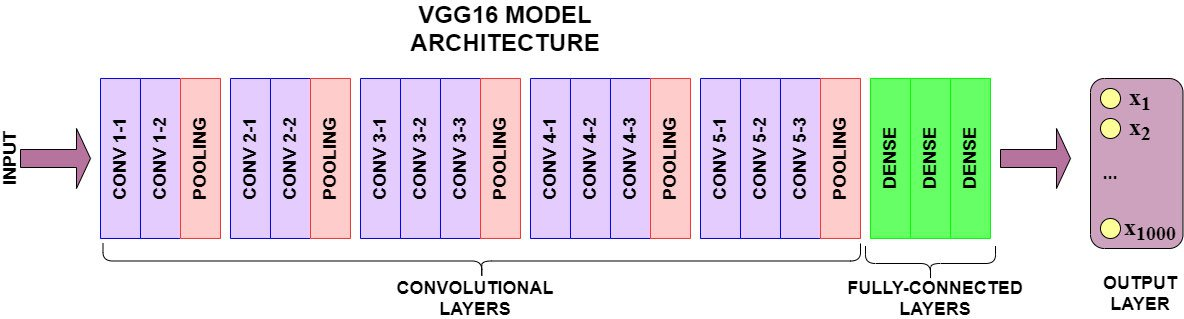

# Task 1: Create Dataset
We would like to create a dataset consisting of apples and bananas. Create a 20 images of each class and store the images in two folders validation and training. Use 15 for training and 5 for validation.
Create separate subfolders for each class. Resulting folder structure.

- /training
  - /apples
  - /bananas
- /validation
  - /apples
  - /bananas

## Initialization of VGG16 network

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG16 model
neural_network = models.vgg16(pretrained=True)

# Freeze all layers for training (no weights are trained)
for param in neural_network.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_classes = 2
neural_network.classifier[6] = nn.Linear(4096, num_classes)
neural_network = neural_network.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 63.8MB/s]


## Questions
Use the following function to get some information about the VGG16 network

`summary(neural_network, (3, 224, 224))`

- How many parameters do you learn?
- How big is the model size in MB?
- What percentage of parameters do you learn?

# Loading datasets
We load the images from two folders into two datasets for training and validation

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/train/', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/val/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Visualizing training dataset

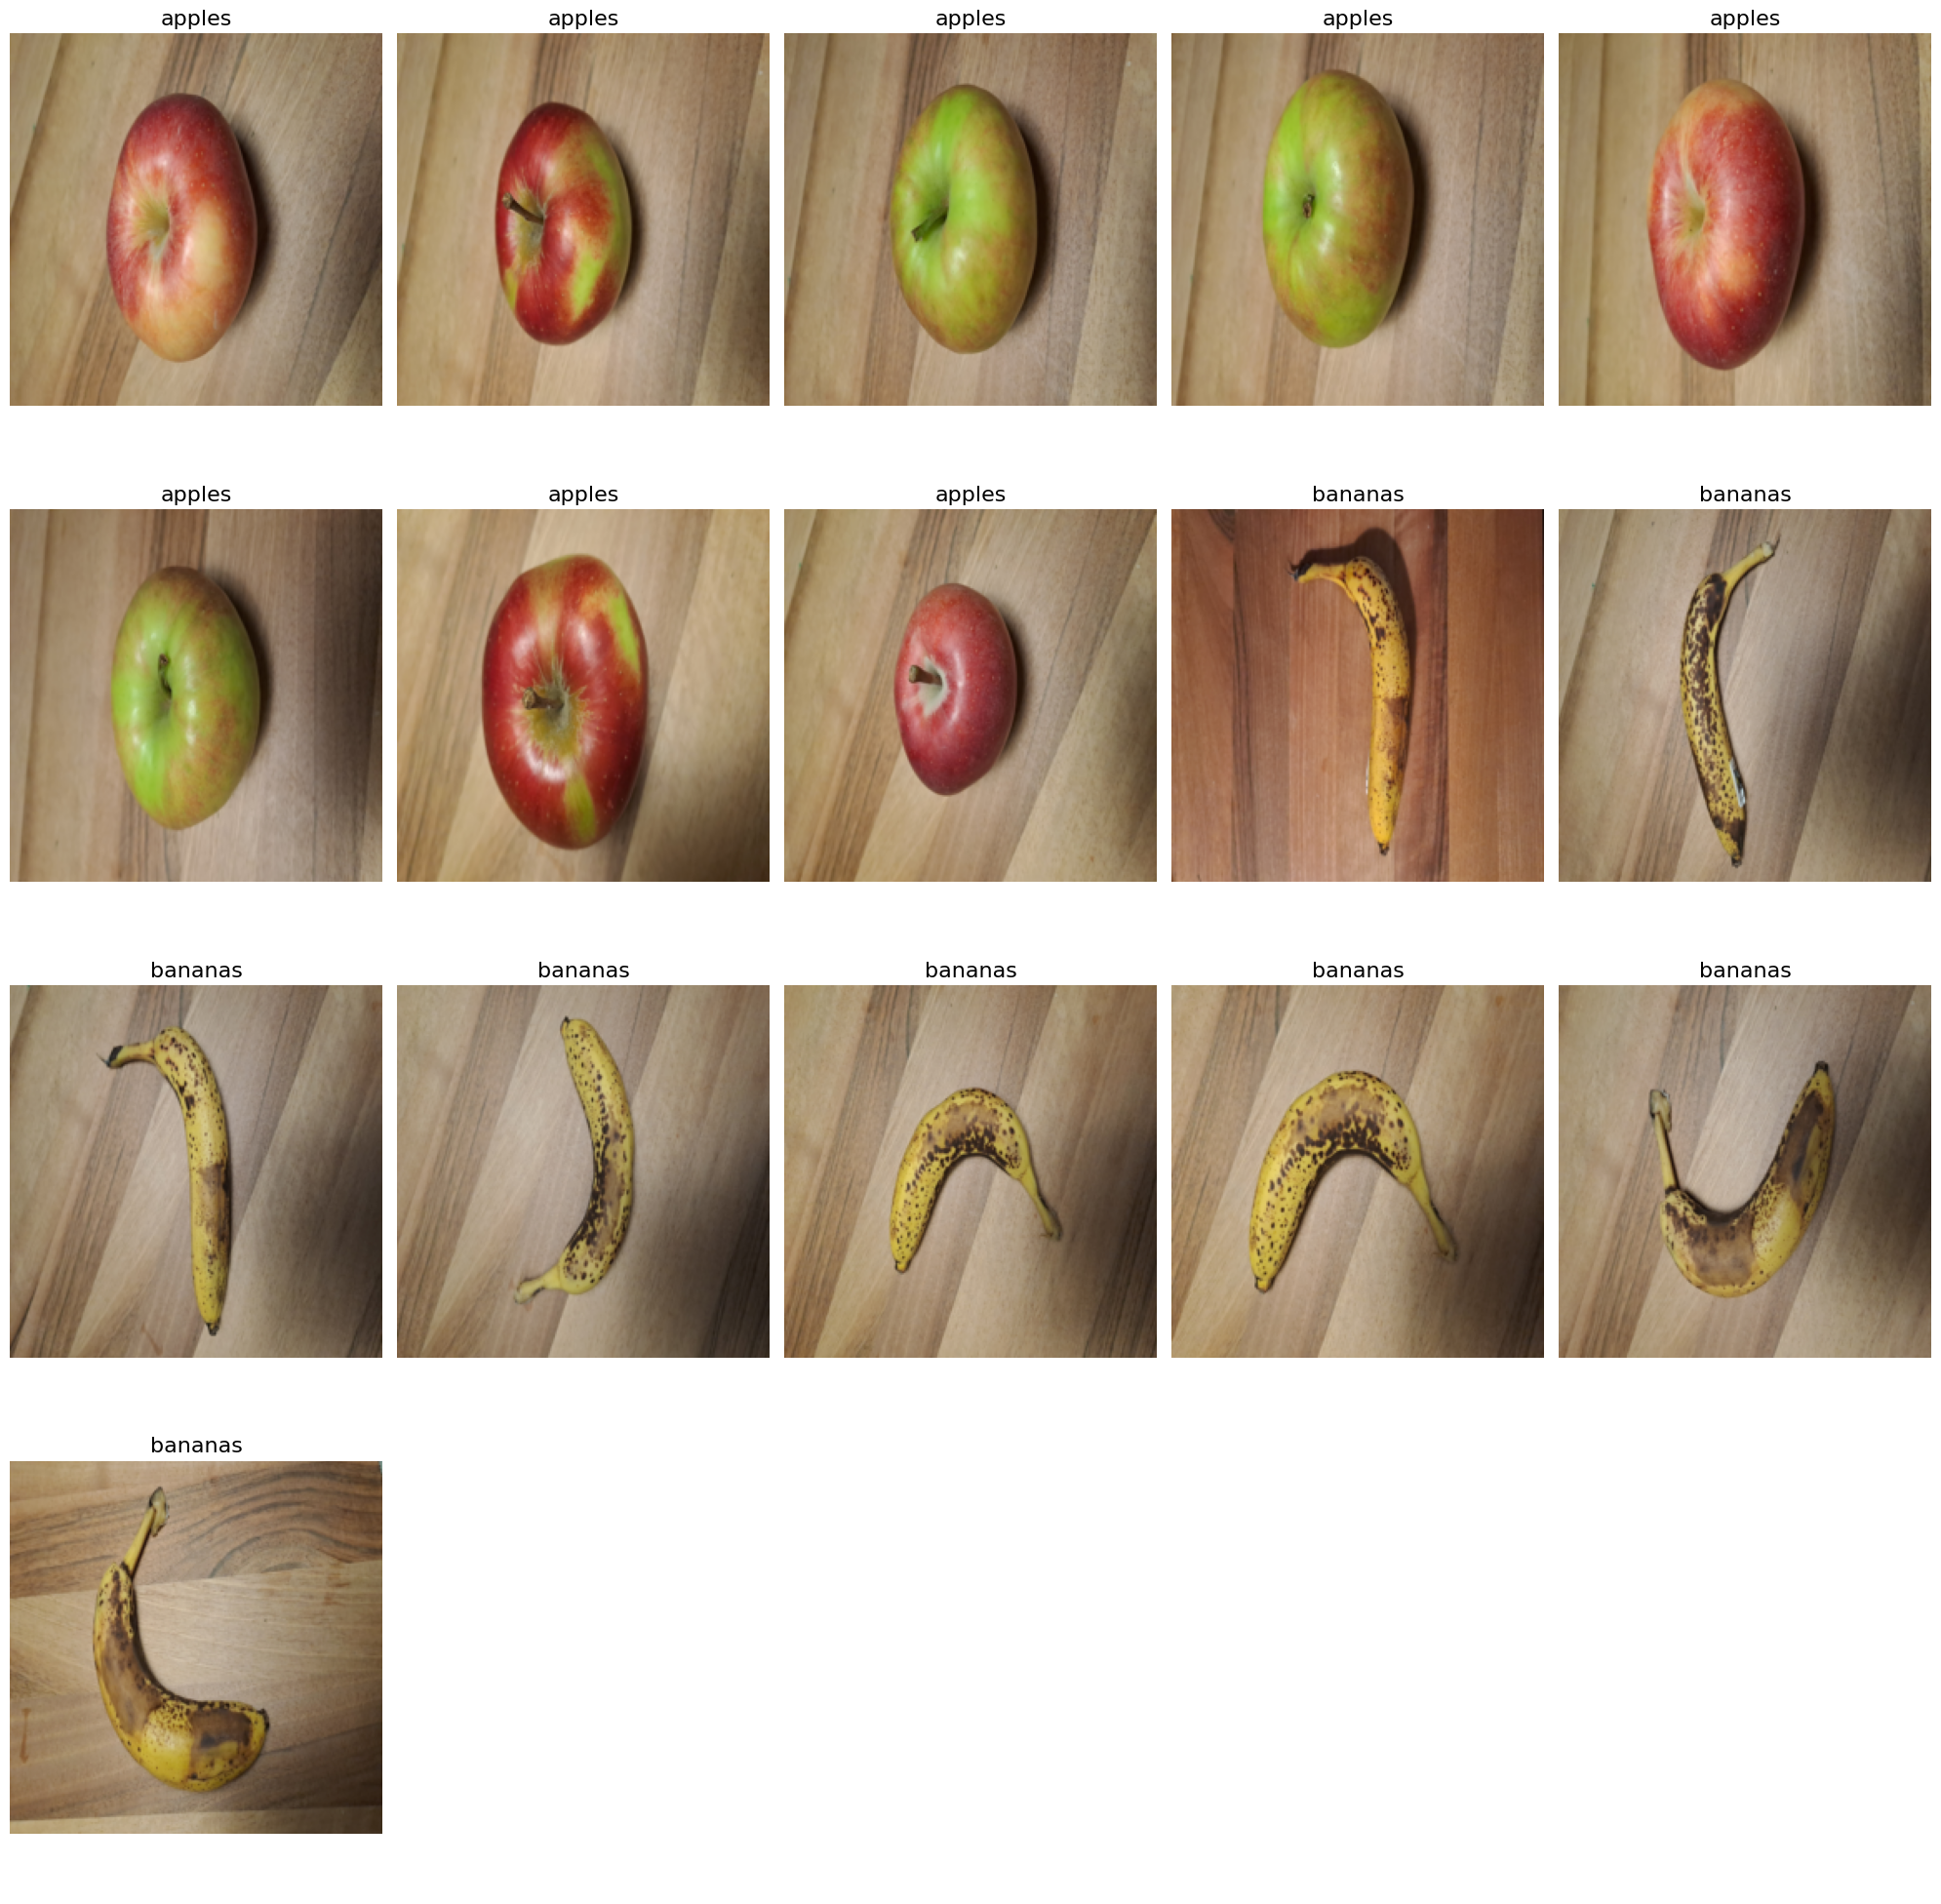

In [ ]:
# Create a function to display images and labels
def show_images_with_labels(dataset, class_names):
    # Get all images and labels from the dataset
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    images, labels = next(iter(loader))

    # Unnormalize the images
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert to (N, H, W, C)
    images = images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    images = images.clip(0, 1)  # Clip values between 0 and 1 for display

    # Display all images
    num_images = len(images)
    num_cols = 5  # Number of columns in the grid
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_names[label.item()], fontsize=16)

    # Hide remaining axes if images < grid size
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display training dataset images with labels
class_names = train_dataset.classes
show_images_with_labels(train_dataset, class_names)


# Task 2: Train the network
Adjust the number of epochs used for training (its set to 1, that is not enough)
- After how many epochs does the training seem to converge?


In [ ]:
# Training loop
num_epochs = 1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.001)

for epoch in range(num_epochs):
    neural_network.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = neural_network(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch [1/10], Loss: 0.7196, Accuracy: 50.00%
Epoch [2/10], Loss: 0.2706, Accuracy: 93.75%
Epoch [3/10], Loss: 0.1677, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0356, Accuracy: 100.00%
Epoch [5/10], Loss: 0.0338, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0114, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0060, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0040, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0045, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0021, Accuracy: 100.00%


# Validate model on validation dataset
We validate the performance of our neural network on unseen data from the validation dataset

In [ ]:
neural_network.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = neural_network(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


Validation Loss: 0.0009, Accuracy: 100.00%


# Task 3: Store trained model into file
- Store the model into a file using the following code

`torch.save(neural_network, 'vgg16_banana_apple.pth')`



# Task 4: Restore trainied model from file
Use the following code to load your serialized model

```
neural_network = torch.load('vgg16_banana_apple.pth')
neural_network.eval()
```


# Task 5: Create a function to predict class from image file
With the following code you can predict the class of an image file

```
from PIL import Image
image_path = "/content/apple.jpg"
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    outputs = model(image)
    _, predicted_class = torch.max(outputs, 1)
    if predicted_class == 0:
        return "Apple"
    else:
        return "Banana"
```

Extend the function below to predict the correct class label given an image and the model

In [6]:
# Example inference
def predict(image_path, model):
    # TODO determine class from given Image
    pass

image_path = "/content/apple.jpg"
print(f"Predicted class: {predict(image_path, neural_network)}")

Predicted class: None


# Task 6: Create an API Endpoint for Inference
- Create an API endpoint with fastapi that allows upload of an Image and returns the label of the uploaded image. Use the given template in the labs folder